In [3]:
import os
import sys
import json
import jsonschema
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

merger = md.Merger(data_dir="data", load_from_raw=True, write_agg=True, load_from_agg=True)
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

# Analyse tests

In [2]:
def create_add(df, col):
    return df.apply(
        lambda row: row[col]-df[
            df["date"]==row["date"] - pd.Timedelta(1, unit='D')
        ][col].max(),
        axis=1
    )

In [3]:
dfs = []
for month in ["2020.10","2020.11","2020.12","2021.01","2021.02","2021.03","2021.04"]:
    with open("data/kpi_hu/{}.json".format(month), 'r') as myfile:
        data_json = json.load(myfile)
        dfs.append(pd.json_normalize(data_json.values()))
df = pd.concat(dfs)
reduced_df = df[["update","tests","infected_pest","infected_other"]].copy()
reduced_df["update"] = pd.to_datetime(reduced_df["update"], format='%Y.%m.%d. %H:%M')
reduced_df["date"] = reduced_df["update"].dt.date
reduced_df["infected"] = reduced_df["infected_pest"]+reduced_df["infected_other"]
reduced_df["add.tests"] = create_add(reduced_df, "tests")
reduced_df["add.infected"] = create_add(reduced_df, "infected")
reduced_df["add.infected/add.tests"] = reduced_df["add.infected"] / reduced_df["add.tests"] * 100
reduced_df.tail()

,update,tests,infected_pest,infected_other,date,infected,add.tests,add.infected,add.infected/add.tests
28,2021-04-27 09:08:00,5308624,37655,216448,2021-04-27,254103,11389.0,-4115.0,-36.131355
29,2021-04-28 08:44:00,5327413,36633,213510,2021-04-28,250143,18789.0,-3960.0,-21.076162
30,2021-04-29 08:52:00,5349792,35708,210220,2021-04-29,245928,22379.0,-4215.0,-18.834622
31,2021-04-30 09:31:00,5373540,34589,206840,2021-04-30,241429,23748.0,-4499.0,-18.944753
32,2021-04-30 17:50:00,5373540,34589,206840,2021-04-30,241429,23748.0,-4499.0,-18.944753


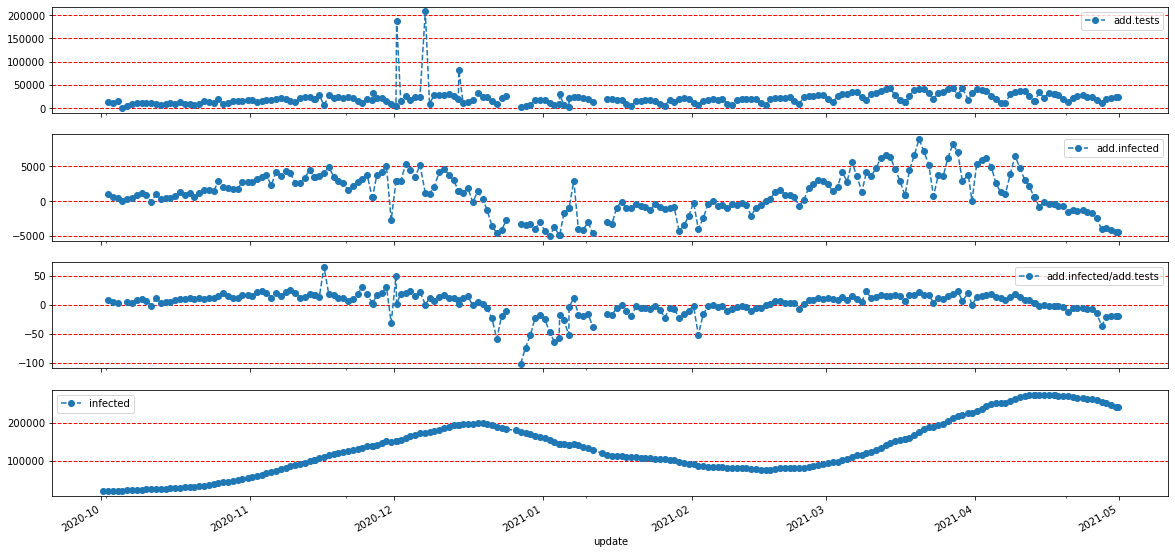

In [4]:
fig, ax = plt.subplots(nrows=4,figsize=(20,10),sharex=True)
reduced_df.plot(x="update", y="add.tests", ax=ax[0], label="add.tests", style="o--")
reduced_df.plot(x="update", y="add.infected", ax=ax[1], label="add.infected", style="o--")
reduced_df.plot(x="update", y="add.infected/add.tests", ax=ax[2], label="add.infected/add.tests", style="o--")
reduced_df.plot(x="update", y="infected", ax=ax[3], label="infected", style="o--")
ax[0].grid(True, which="both", axis="y", color='r', linestyle='--', linewidth=1)
ax[1].grid(True, which="both", axis="y", color='r', linestyle='--', linewidth=1)
ax[2].grid(True, which="both", axis="y", color='r', linestyle='--', linewidth=1)
ax[3].grid(True, which="both", axis="y", color='r', linestyle='--', linewidth=1)
plt.show()

# Deaths stat

In [5]:
# merger.merge_deaths_df()
df = merger.load_deaths_df()

/opt/conda/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [6]:
df["Kor_class"] = df["Kor"].apply(lambda cell: cell - (cell % 10), meta=('Kor', 'int64'))
df["week"] = df["date"].dt.week + df["date"].dt.year * 100
df["day"] = df["date"].apply(
    lambda cell: cell - pd.to_timedelta(cell.dayofweek, unit="D"), meta=('date', 'datetime64[ns]')
)
df_group = df.groupby(["day", "Kor_class"]).agg({"Nem":"count"}).reset_index()
pd_df_group = df_group.compute()

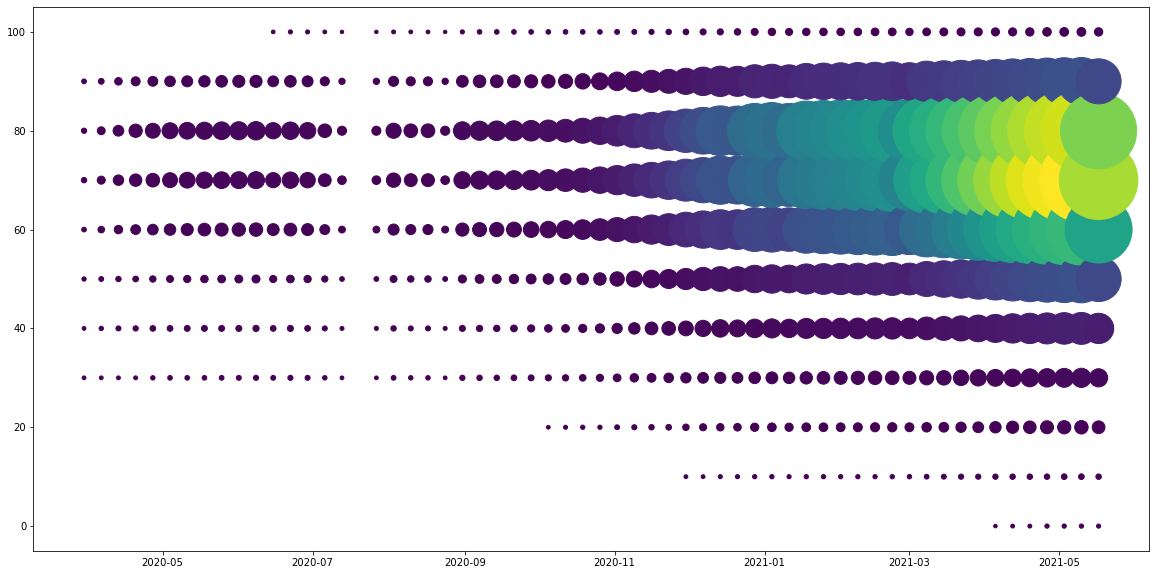

In [7]:
plt.subplots(figsize=(20,10))
plt.scatter(
    x=pd_df_group["day"], y=pd_df_group["Kor_class"], 
    s=10+pd_df_group["Nem"]**0.8, c=pd_df_group["Nem"])
plt.show()

# Forecast

In [8]:
SIR = merger.show_kpi_hu()[["update","deaths","infected","recovered"]].copy()
SIR.columns = ["date","Deaths","Confirmed","Recovered"]
SIR["I"] = SIR["Confirmed"]-SIR["Deaths"]-SIR["Recovered"]
SIR["RD"] = SIR["Deaths"]+SIR["Recovered"]
SIR["D"] = SIR["Deaths"]
SIR.tail()

,date,Deaths,Confirmed,Recovered,I,RD,D
2021-05-19 09:08:00,2021-05-19 09:08:00,29329.0,799588.0,648513.0,121746.0,677842.0,29329.0
2021-05-20 09:08:00,2021-05-20 09:08:00,29380.0,800368.0,655959.0,115029.0,685339.0,29380.0
2021-05-21 09:01:00,2021-05-21 09:01:00,29427.0,801025.0,661564.0,110034.0,690991.0,29427.0
2021-05-22 09:09:00,2021-05-22 09:09:00,29475.0,801672.0,665552.0,106645.0,695027.0,29475.0
2021-05-22 17:22:00,2021-05-22 17:22:00,29475.0,801672.0,665552.0,106645.0,695027.0,29475.0


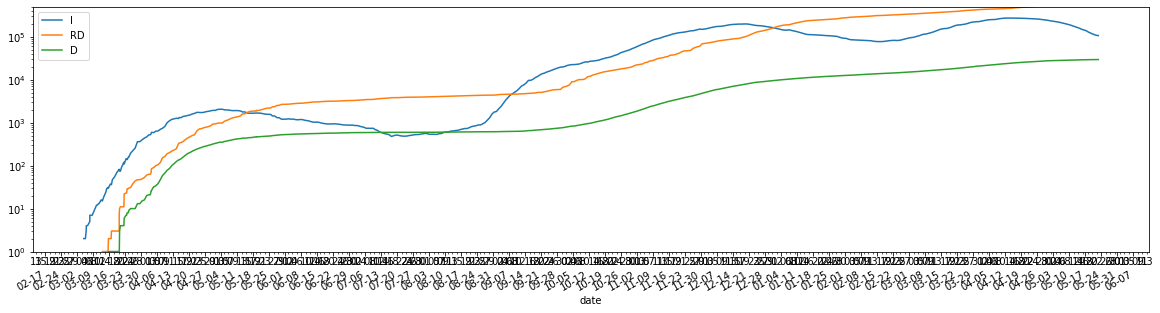

In [9]:
fig, ax = plt.subplots(figsize=(20,5))

ax.xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=2))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%m-%d'))
ax.set_yscale("log")
ax.set_ylim(1, 500000)

SIR.plot(x="date",y=["I","RD","D"],ax=ax)
plt.show()

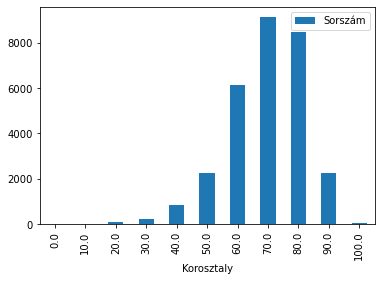

In [10]:
deaths_df = pd.read_json("data/deaths_hu/latest.json")
deaths_df["Nem"] = deaths_df["Nem"].apply(lambda cell: cell[0:1].capitalize() if isinstance(cell, str) else cell)
deaths_df["Korosztaly"] = deaths_df["Kor"] - deaths_df["Kor"] % 10
deaths_df.groupby(["Korosztaly"]).agg({"Sorszám":"count"}).plot(kind="bar")
plt.show()

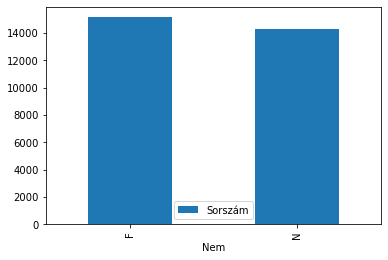

In [11]:
deaths_df.groupby(["Nem"]).agg({"Sorszám":"count"}).plot(kind="bar")
plt.show()

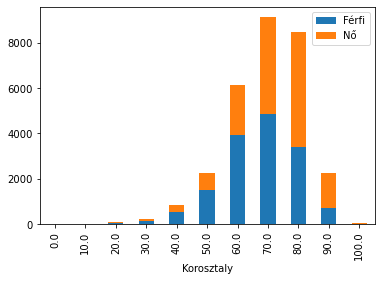

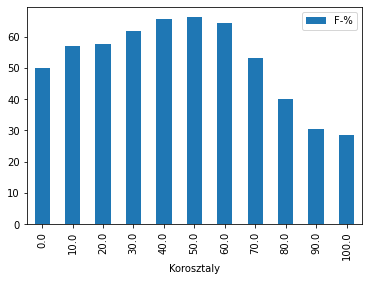

In [12]:
stats_df = deaths_df[deaths_df["Nem"]!=""].groupby(["Korosztaly","Nem"]).agg({"Sorszám":"count"}).unstack('Nem')
columns = ["Férfi","Nő"]
stats_df.columns = columns
stats_df["F-%"] = stats_df["Férfi"]/(stats_df["Férfi"]+stats_df["Nő"])*100
stats_df[columns].plot(kind="bar", stacked=True)
stats_df[["F-%"]].plot(kind="bar")
plt.show()